In [1]:
import os
import pydicom  
import numpy as np
import matplotlib.pyplot as plt
import dicom2nifti
from scipy import ndimage
import cv2

In [2]:
dicom = pydicom.dcmread('C:/Users/deepanshu.sharma/OneDrive - Plaksha University/Desktop/archive/moderate/moderate/0/')
# Read all DICOM file
dicom_image = dicom.pixel_array 



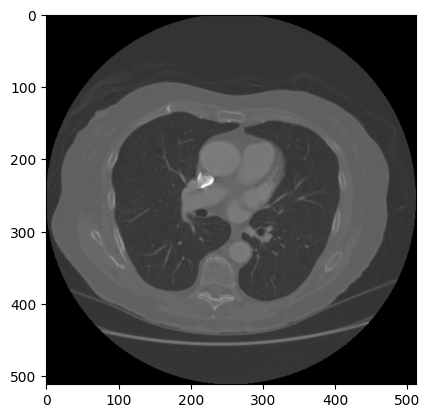

In [3]:
plt.imshow(dicom_image, cmap = 'gray')

In [4]:
dicom_image.min()

-1024

In [5]:
dicom_image.max()

4095

In [6]:
dicom

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 206
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.253091614838702797912601638880
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.6279.6001.25309

In [7]:
window_center = dicom.WindowCenter
window_width = dicom.WindowWidth
intercept = dicom.RescaleIntercept
slope = dicom.RescaleSlope

In [8]:
print(window_center , window_width, intercept, slope)

-600 1600 -1024 1


In [9]:
def window_image(img, window_center,window_width, intercept, slope, rescale=True):
    img = (img*slope +intercept) #for translation adjustments given in the dicom file. 
    print(np.unique(img))
    img_min = window_center - window_width//2 #minimum HU level
    img_max = window_center + window_width//2 #maximum HU level
    img[img<img_min] = img_min #set img_min for all HU levels less than minimum HU level
    img[img>img_max] = img_max #set img_max for all HU levels higher than maximum HU level
    return img

In [10]:
output = window_image(dicom_image, window_center, window_width, intercept, slope, rescale = False)

[-2048. -1024. -1023. ...  3036.  3039.  3071.]


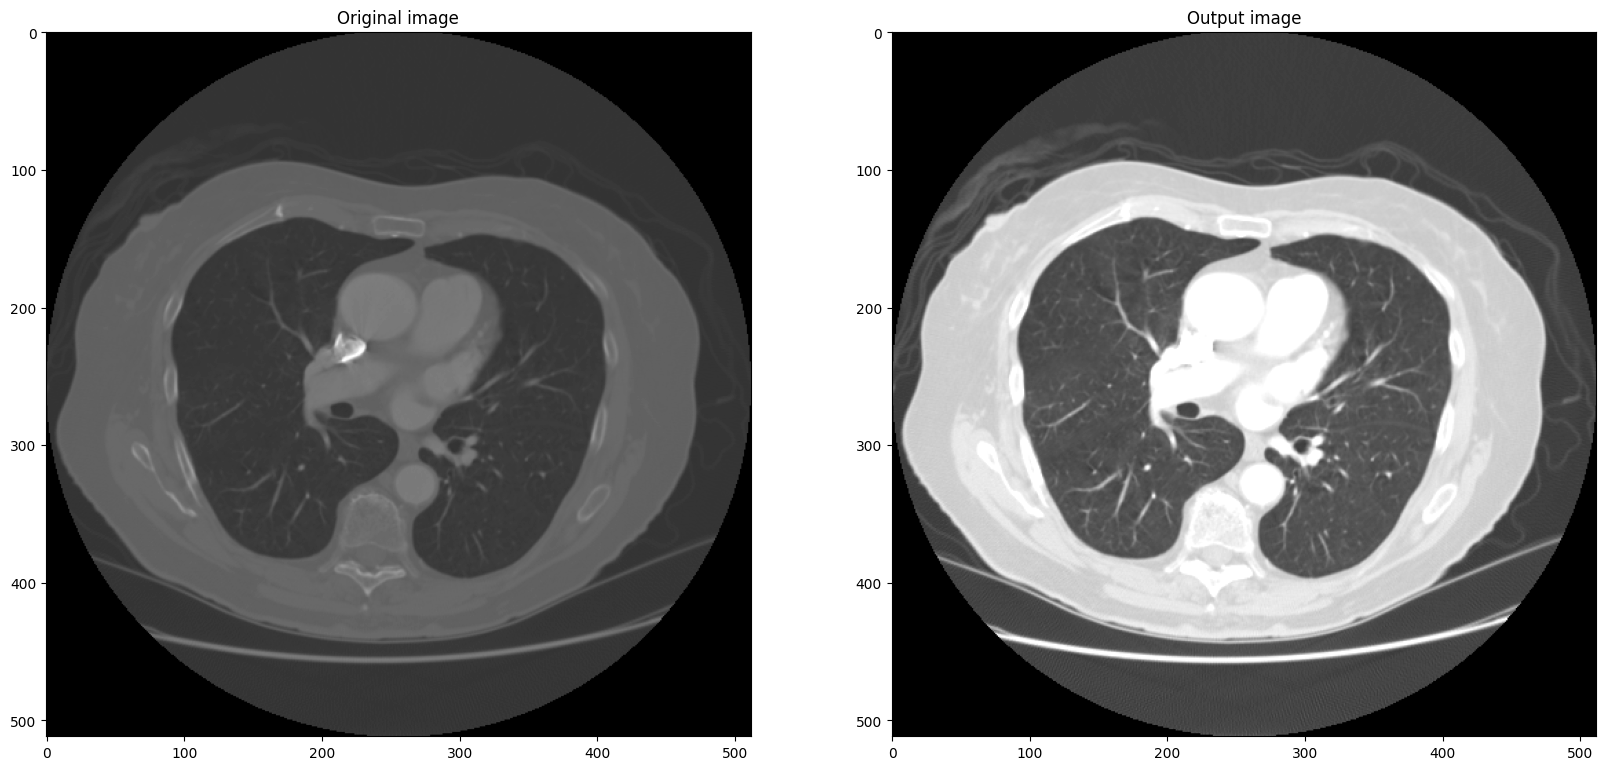

In [11]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(dicom_image, cmap=plt.cm.gray)

ax1.set_title("Original image")

ax2.imshow(output, cmap=plt.cm.gray)

ax2.set_title("Output image")

plt.show()
fig.savefig("D:/31.png")

In [139]:
output.min()

-1400.0

In [140]:
output.max()

200.0

In [12]:
image_normalized = cv2.normalize(output, None, 0, 255, cv2.NORM_MINMAX)
image_normalized = np.uint8(image_normalized)

In [13]:
edges = cv2.Canny(image_normalized, 50, 150)

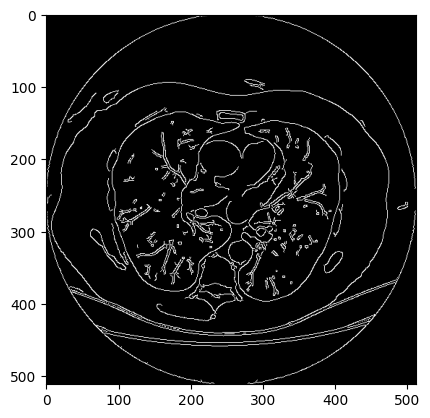

In [14]:
plt.imshow(edges, cmap='gray')

[[[161  94]]

 [[160  95]]

 [[154  95]]

 ...

 [[186  95]]

 [[180  95]]

 [[179  94]]]


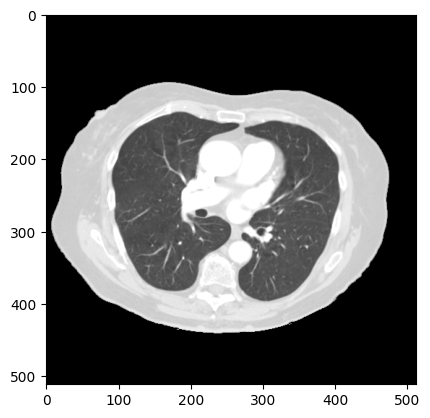

In [16]:
# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour by area
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
else:
    largest_contour = np.array([])
print(largest_contour)
# Create a mask with the same dimensions as the image
mask = np.zeros_like(image_normalized)

# Draw the largest contour on the mask
if largest_contour.size > 0:
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

# Apply the mask to the original image
masked_image = cv2.bitwise_and(image_normalized, image_normalized, mask=mask)

plt.imshow(masked_image, cmap='gray')

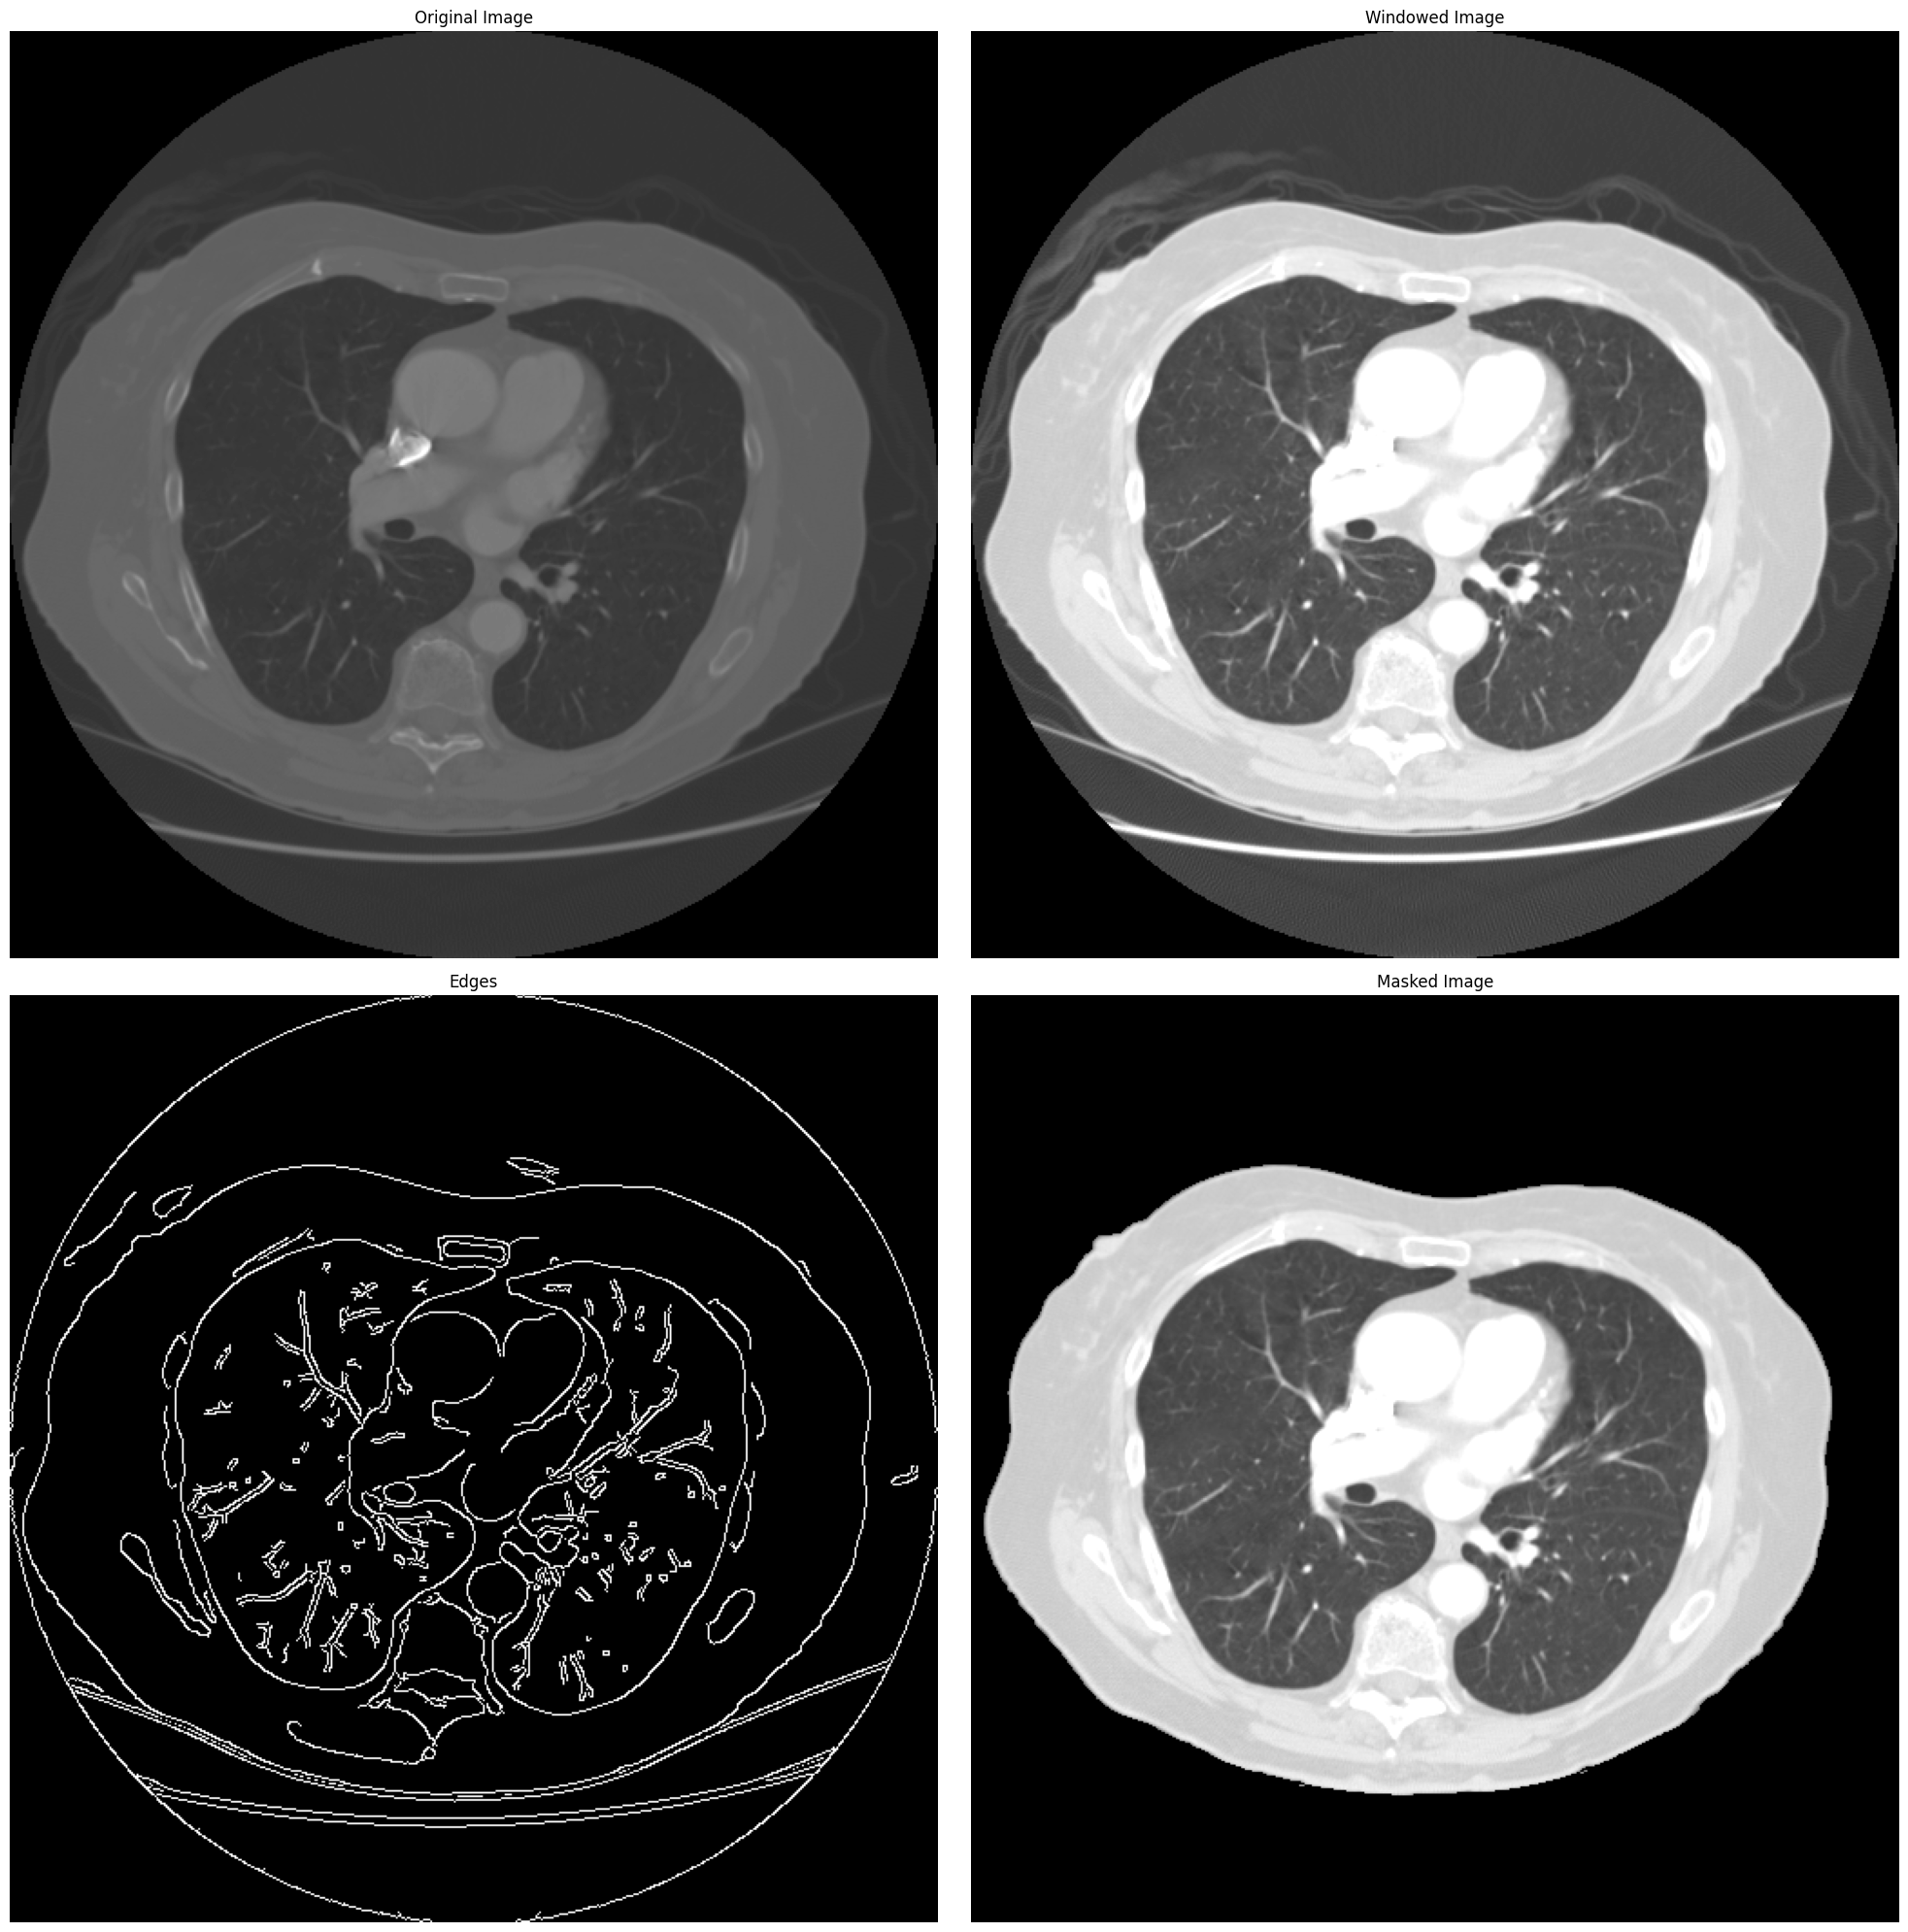

In [19]:

# Display the results using matplotlib
fig = plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.title('Original Image')
plt.imshow(dicom_image, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Windowed Image')
plt.imshow(output, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Edges')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Masked Image')
plt.imshow(masked_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
fig.savefig("D:/add.png")


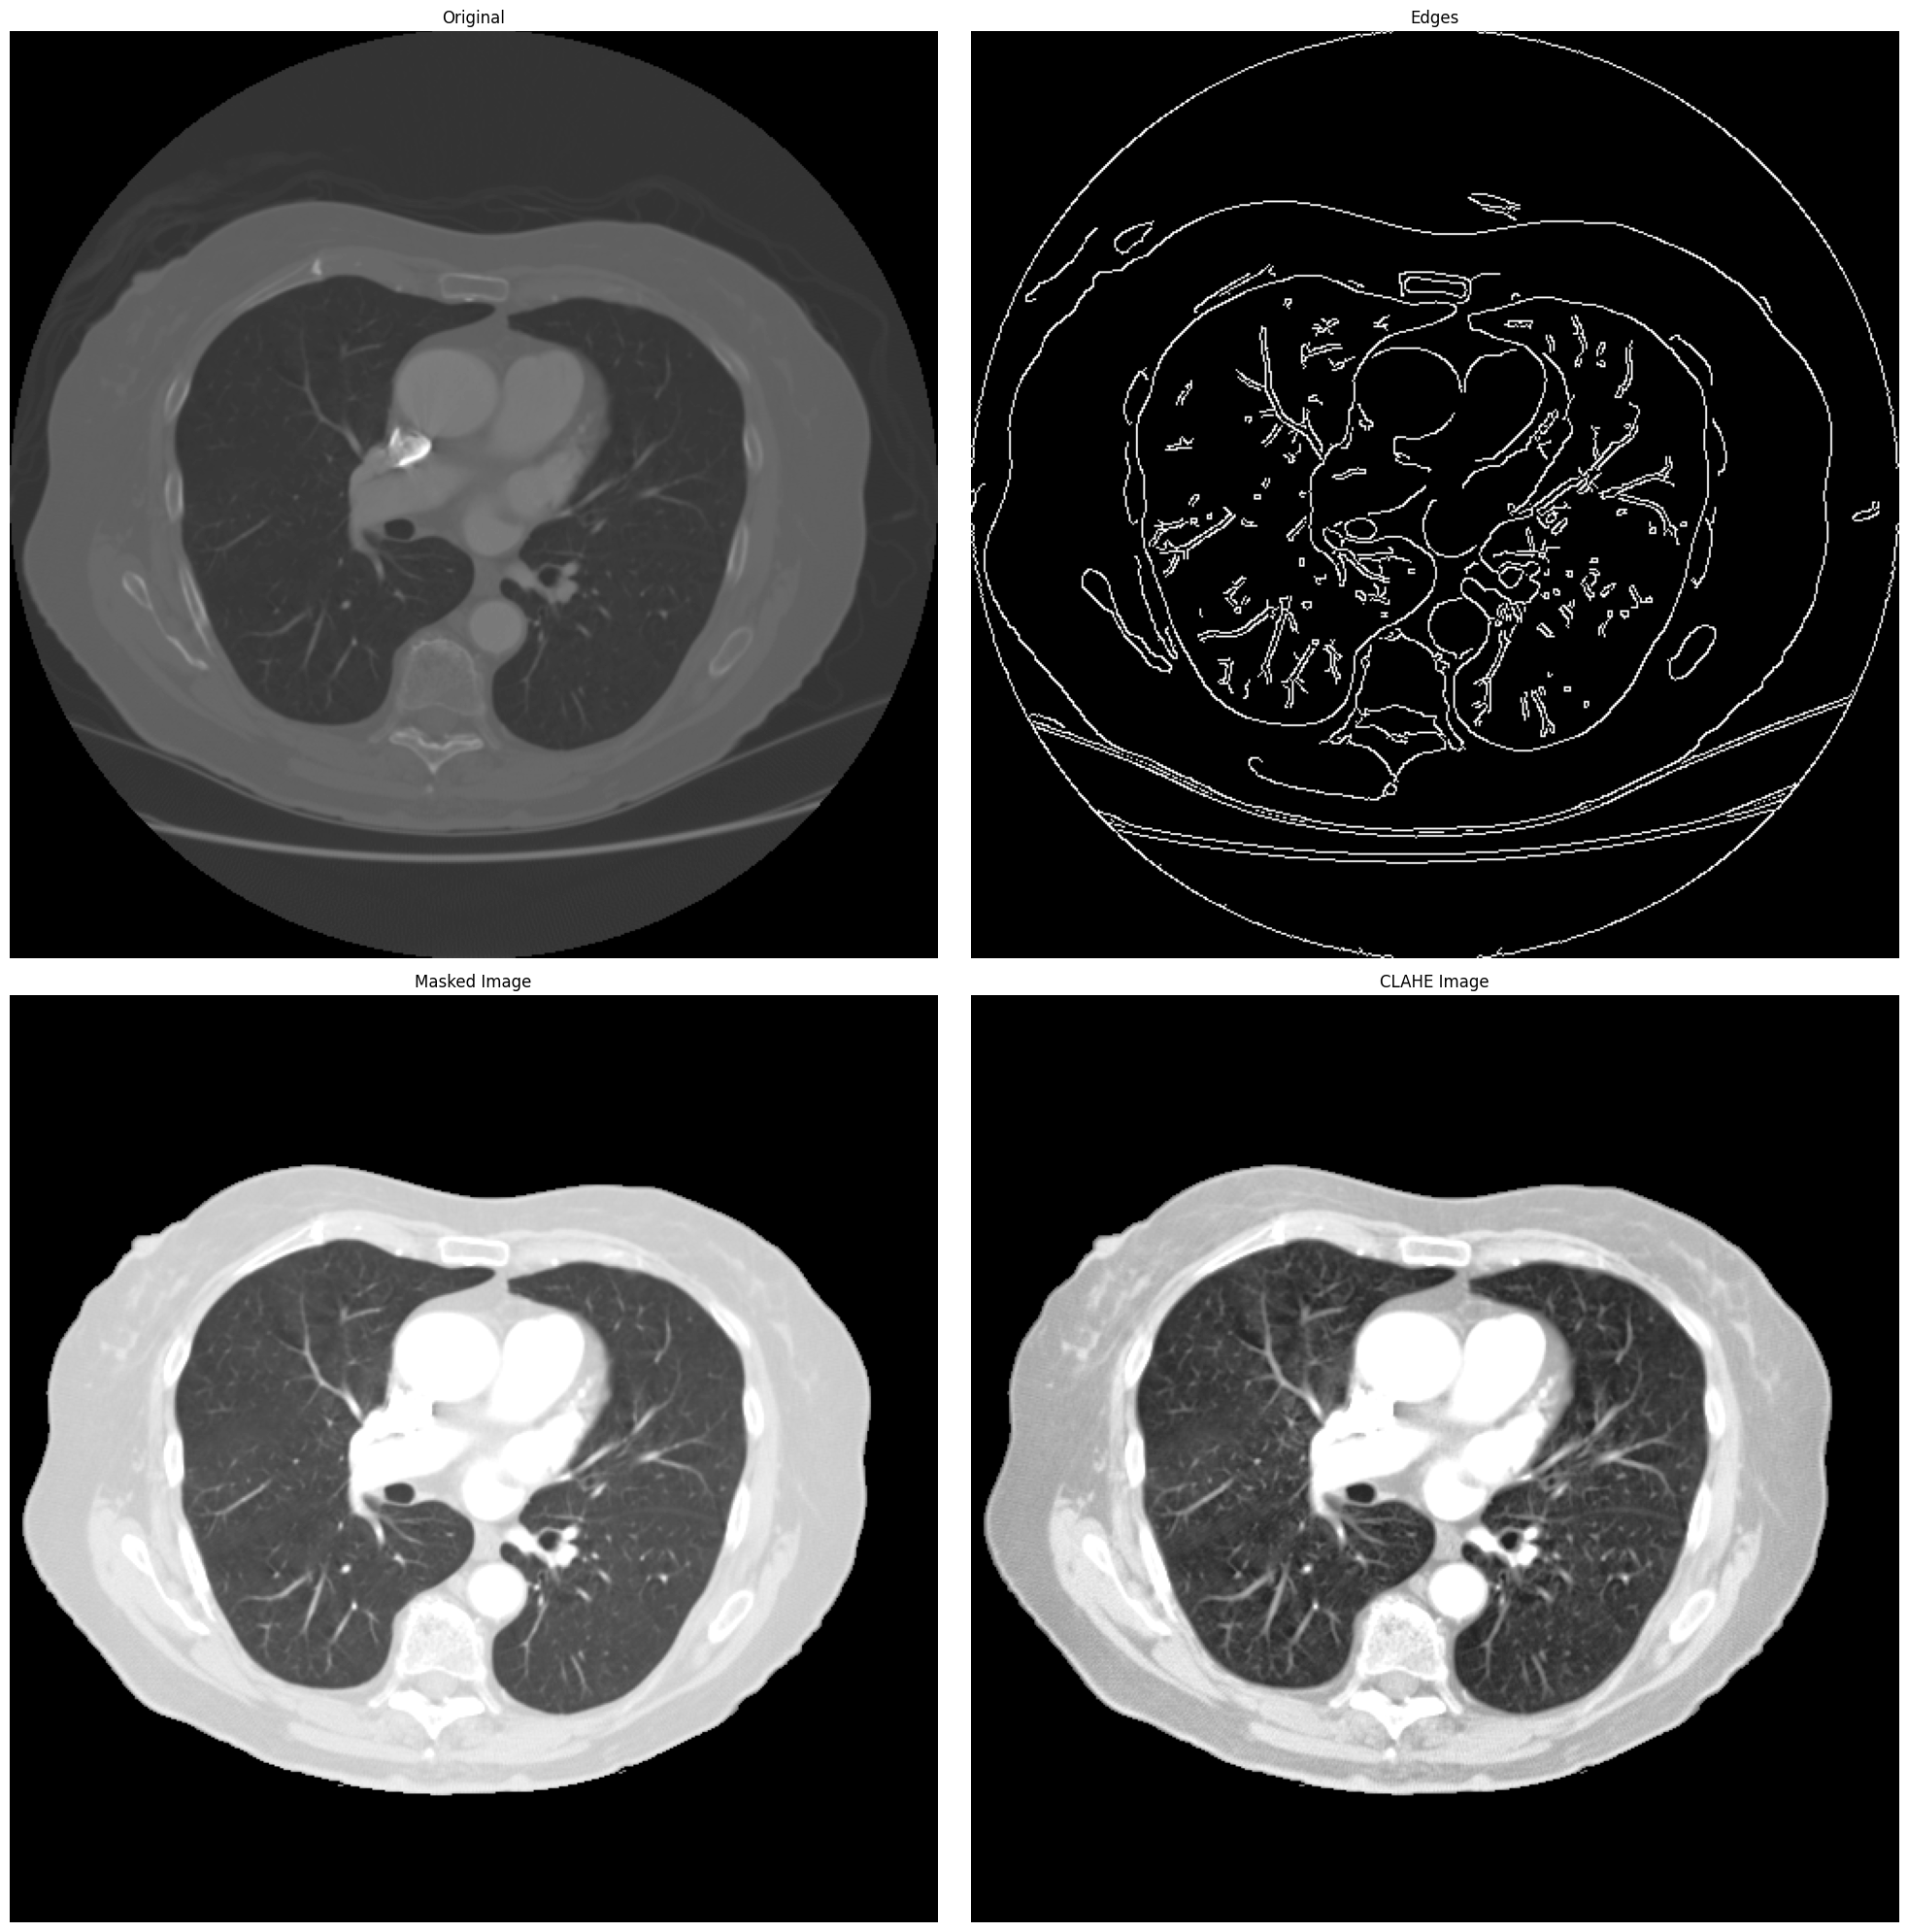

In [22]:

# Display the results using matplotlib
fig = plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.title('Original')
plt.imshow(dicom_image, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Edges')
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Masked Image')
plt.imshow(masked_image, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('CLAHE Image')
plt.imshow(clahe_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
fig.savefig("D:/add.png")


In [18]:
clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(5,5))
clahe_image = clahe.apply(masked_image.astype(np.uint8))

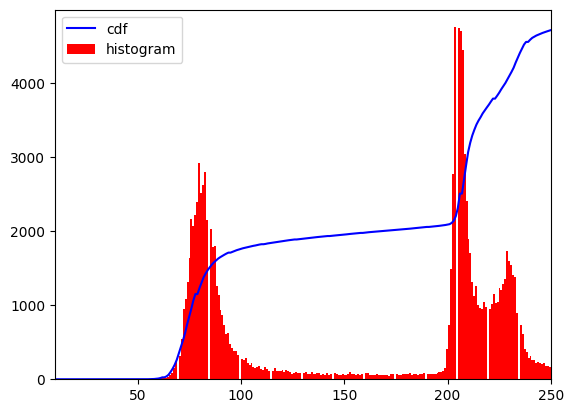

In [28]:
image_norm_hist,image_norm_bins = np.histogram(masked_image.flatten(),256,[10,250])
cdf = image_norm_hist.cumsum()
cdf_normalized = cdf * float(image_norm_hist.max()) / cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(masked_image.flatten(),256,[10,250], color = 'r')
plt.xlim([10,250])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()


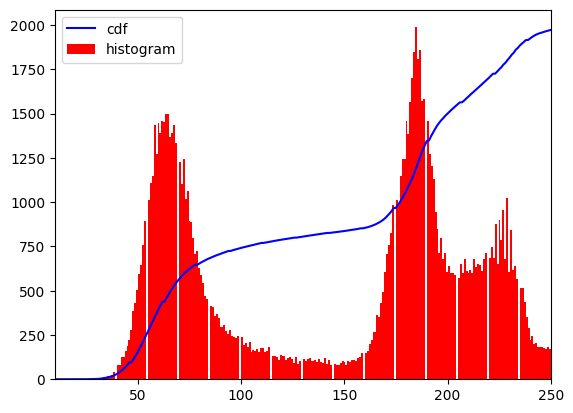

In [27]:
image_norm_hist,image_norm_bins = np.histogram(clahe_image.flatten(),256,[10,250])
cdf = image_norm_hist.cumsum()
cdf_normalized = cdf * float(image_norm_hist.max()) / cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(clahe_image.flatten(),256,[10,250], color = 'r')
plt.xlim([10,250])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()


In [29]:
img_example_hist = cv2.equalizeHist(masked_image)

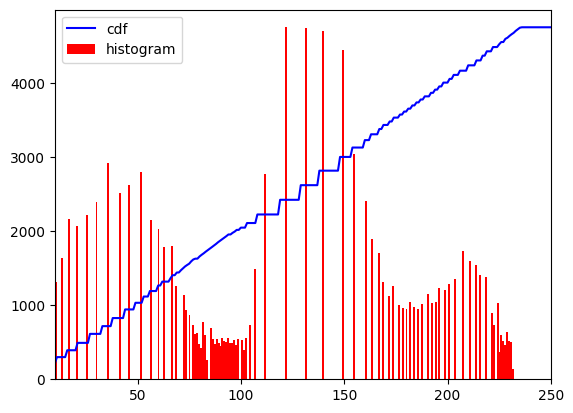

In [30]:
image_norm_hist,image_norm_bins = np.histogram(img_example_hist.flatten(),256,[10,250])
cdf = image_norm_hist.cumsum()
cdf_normalized = cdf * float(image_norm_hist.max()) / cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(img_example_hist.flatten(),256,[10,250], color = 'r')
plt.xlim([10,250])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()


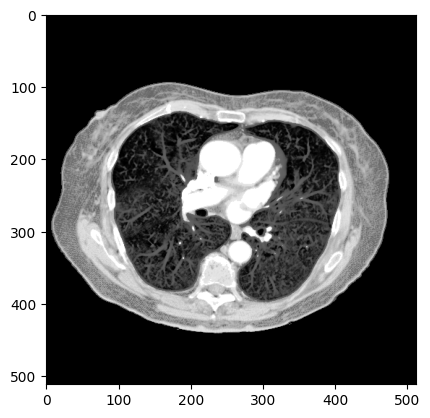

In [32]:
plt.imshow(img_example_hist, cmap='gray')

In [53]:
# Define Sobel kernels
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])

# Apply Sobel filter in the x direction
sobel_x_result = ndimage.convolve(image_normalized, sobel_x)

# Apply Sobel filter in the y direction
sobel_y_result = ndimage.convolve(image_normalized, sobel_y)

# Compute the magnitude of gradients
sobel_mag = np.sqrt(sobel_x_result**2 + sobel_y_result**2)
#sobel_mag = sobel_mag.astype(np.uint8)
print(sobel_mag)
print(sobel_mag.shape)
print(sobel_mag.dtype)
print(np.unique(sobel_mag))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(512, 512)
float16
[ 0.     1.414  2.     2.828  3.162  4.     4.242  4.473  5.098  5.656
  5.832  6.     6.324  6.48   7.07   7.21   7.617  8.     8.125  8.25
  8.484  8.6    8.945  9.055  9.164  9.484  9.9   10.    10.195 10.3
 10.68  10.77  11.05  11.31  11.4   11.49  11.664 11.75  12.    12.086
 12.164 12.41  12.65  12.73  12.805 12.96  13.04  13.34  13.414 13.64
 13.93  14.    14.14  14.21  14.42  14.49  14.56  14.766 15.03  15.1
 15.234 15.3   15.555 15.62  15.81 ]


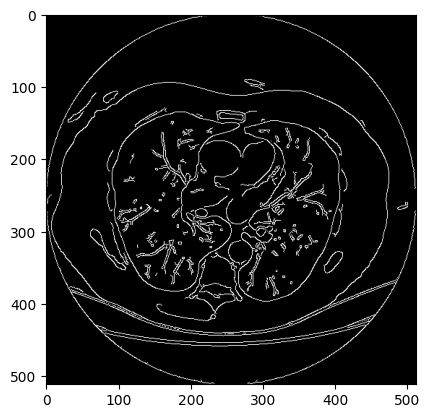

In [16]:
# Normalize the image to the range 0-255 through cv2.
image_normalized = cv2.normalize(dicom_image, None, 0, 255, cv2.NORM_MINMAX)
image_normalized = np.uint8(image_normalized)


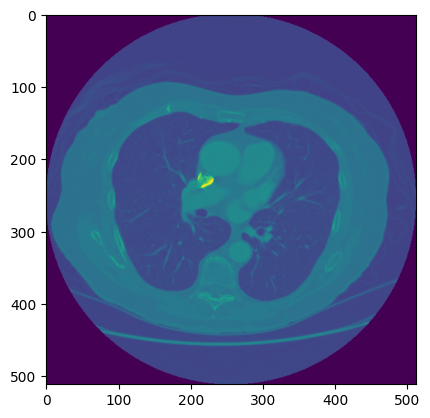

In [33]:
plt.imshow(image_normalized)

In [24]:
np.unique(image_normalized)

array([  0,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       194, 195, 196, 199, 200, 201, 202, 203, 204, 207, 208, 209, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
       224, 228, 229, 230, 231, 233, 234, 235, 236, 238, 239, 24

In [31]:
# Apply thresholding to create a binary image
_, binary_image = cv2.threshold(image_normalized, 250, 255, cv2.THRESH_BINARY)

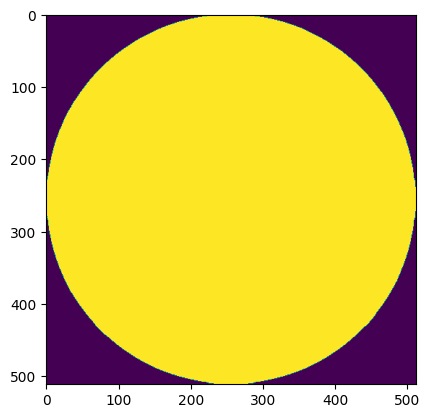

In [32]:
blur = cv2.GaussianBlur(image_normalized, (5,5), 0)
_, th2 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(th2)